In [393]:
import numpy as np
import tqdm

In [394]:
# load mnist dataset

def fetch(url):
  import requests, gzip, os, numpy, hashlib
  fp = os.path.join("/tmp", hashlib.md5(url.encode('utf-8')).hexdigest())
  if os.path.isfile(fp):
    with open(fp, 'rb') as f:
      data = f.read()
  else:
    with open(fp, 'wb') as f:
      data = requests.get(url).content
      f.write(data)
  return numpy.frombuffer(gzip.decompress(data), dtype=numpy.uint8).copy()

Xtr = fetch("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[0x10:].reshape(-1,28,28)
Ytr = fetch("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]
Xval= fetch("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[0x10:].reshape(-1,28,28)
Yval= fetch("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]

In [395]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt

class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.l1 = nn.Linear(28*28, 228, bias=False)
    self.l2 = nn.Linear(228, 10, bias=False)

  def forward(self, x, y=None):
    x = F.gelu(self.l1(x))
    x = self.l2(x)
    loss = None
    if y is not None:
      loss = F.cross_entropy(x, y)
    return x, loss

In [396]:
model = Net()
optim = torch.optim.AdamW(model.parameters(), lr=3e-4)
losses, accuracies = [], []

In [397]:
BS = 32
epoch = 1000

for i in (t := tqdm.trange(epoch)):
  # mini batch
  idx = torch.randint(0, len(Xtr), size=(BS,))
  X = torch.tensor(Xtr[idx]).reshape(-1, 28*28).float()
  Y = torch.tensor(Ytr[idx]).long()
  
  # forward
  out,loss = model(X,Y)
  preds = out.softmax(-1)
  cat = torch.argmax(preds, dim=-1)
  accuracy = (cat == Y).float().mean()

  # backward
  model.zero_grad()
  loss.backward()
  
  # step 
  optim.step()

  # track
  losses.append(loss.item())
  accuracies.append(accuracy.item())
  t.set_description(f"{i} | loss: {loss.item():.4f} | accuracy: {accuracy:.4f}")

999 | loss: 0.7338 | accuracy: 0.8750: 100%|██████████| 1000/1000 [00:11<00:00, 88.79it/s]


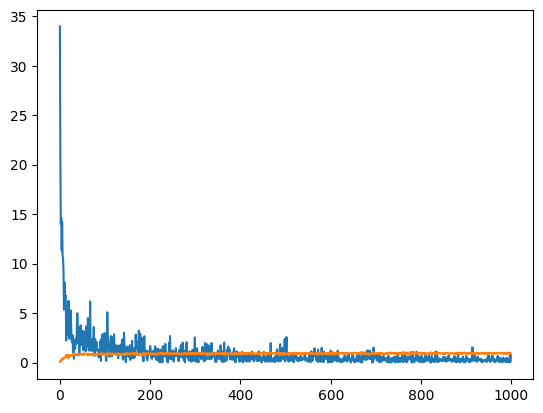

In [398]:
# this is too ugly to see
plt.plot(losses);
plt.plot(accuracies);

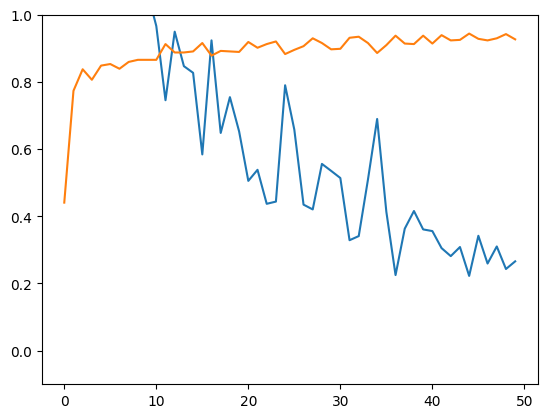

In [399]:
plt.ylim(-0.1, 1)
plt.plot(torch.tensor(losses).view(-1, 20).mean(-1).tolist());
plt.plot(torch.tensor(accuracies).view(-1, 20).mean(-1).tolist());

In [400]:
# eval Train
with torch.no_grad():
  Y_preds = torch.argmax((model(torch.tensor(Xtr).view(-1, 28*28).float())[0]).softmax(-1), dim=-1).numpy()
  print((Y_preds == Ytr).mean())

# eval Test
with torch.no_grad():
  Y_val_preds = torch.argmax((model(torch.tensor(Xval).view(-1, 28*28).float())[0]).softmax(-1), dim=-1).numpy()
  print((Y_val_preds == Yval).mean())

0.92985
0.9273


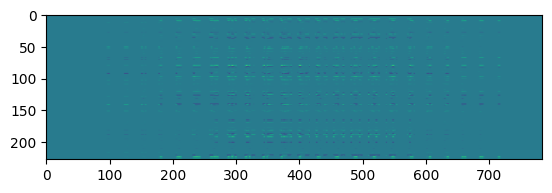

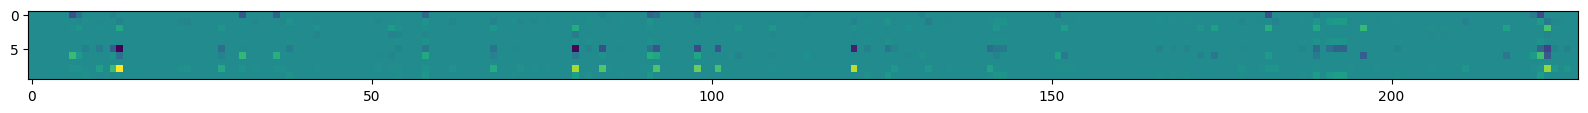

In [401]:
plt.imshow(model.l1.weight.grad)
plt.figure(figsize=(20,20))
plt.imshow(model.l2.weight.grad)

In [402]:
l1 = model.l1.weight.detach().numpy().T
l2 = model.l2.weight.detach().numpy().T

In [403]:
# numpy forward and backward pass
def forward_backward(x, y):
  x_l1 = x.dot(l1)
  x_relu = np.maximum(x_l1, 0) # I used gelu for torch, relu for np
  logits = x_relu.dot(l2)
  lmax = logits.max(1)
  lnorm = logits - lmax.reshape(-1,1) # broadcasting!
  counts = np.exp(lnorm)
  counts_sum = counts.sum(1).reshape(-1,1) # broadcasting
  c_sum_inv = counts_sum**-1
  probs = counts * c_sum_inv
  eps = 1e-15 # numerical stability
  probs = np.maximum(probs, eps)

  logprobs = np.log(probs) # log likelihood
  loss = -logprobs[range(len(x)), y].mean()

  ###################
  # manual backprop #

  dlogprobs = np.zeros_like(logprobs)
  dlogprobs[range(len(x)), y] = -1.0/len(x)
  dprobs = dlogprobs * 1.0/probs
  dcounts = dprobs * c_sum_inv
  dc_sum_inv = (dprobs * counts).sum(1).reshape(-1, 1)
  dcounts_sum = dc_sum_inv * (-counts_sum**-2)
  dcounts += dcounts_sum * np.ones_like(counts)
  dlnorm = dcounts * counts
  dlogits = dlnorm.copy()
  dlmax = (-dlnorm).sum(1)
  max_idx = np.argmax(logits, 1)
  one_hot_max = np.eye(logits.shape[1])[max_idx]
  dlogits += dlmax[:, np.newaxis] * one_hot_max
  dl2 = x_relu.T.dot(dlogits) 
  dx_relu = np.dot(dlogits,l2.T)
  dx_l1 = dx_relu * (x_l1 > 0).astype(np.float32)
  dl1 = x.T.dot(dx_l1)
  return loss, logits, dl1, dl2

idx = range(0,32)
loss, logits, dl1, dl2 = forward_backward(Xtr[idx].reshape(-1, 28*28),Ytr[idx])


In [404]:
def layer_init(i,o):
  w = np.random.uniform(-1., 1., size=(i,o)) / np.sqrt(i*o)
  return w.astype(np.float32)

np.random.seed(1223)
l1 = layer_init(28*28, 228)
l2 = layer_init(228, 10)

In [405]:
lr = 3e-4
BS = 32
epoch = 1000

losses, accuracies = [], []
for i in (t:=tqdm.trange(epoch)):
  idx = np.random.randint(0, len(Xtr), (BS,))
  X = Xtr[idx].reshape(-1, 28*28)
  Y = Ytr[idx]
  loss, logits, dl1, dl2 = forward_backward(X,Y)
  cat = np.argmax(logits, 1)
  accuracy = (cat == Y).mean()
  # step
  l1 = l1 - (dl1*lr) 
  l2 = l2 - (dl2*lr)
  
  loss = loss.mean()
  losses.append(loss)
  accuracies.append(accuracy)
  t.set_description(f"{i} | loss: {loss:.4f} | accuracy: {accuracy:.4f}")


999 | loss: 0.2299 | accuracy: 0.9375: 100%|██████████| 1000/1000 [00:04<00:00, 237.00it/s]


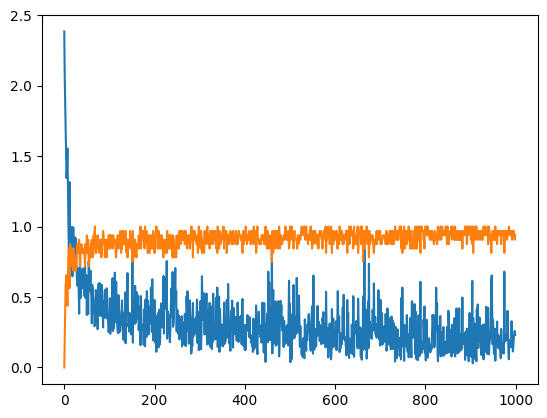

In [406]:
# Superior than pytorch's initilization
plt.plot(losses)
plt.plot(accuracies)

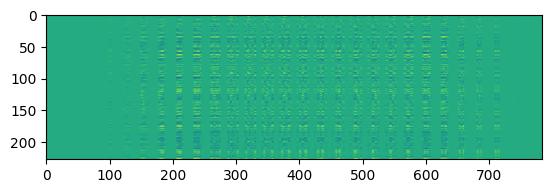

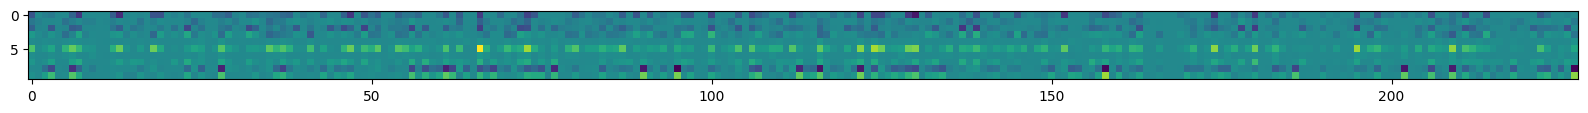

In [407]:
plt.imshow(dl1.T)
plt.figure(figsize=(20,20))
plt.imshow(dl2.T)